## Project description

<b>Context</b><br/>
We analyze the data of a large online store. Together with the marketing department, we have prepared a list of hypotheses for increasing revenue.<br/>
We will prioritize the hypotheses, run an A/B test, and analyze the results.

## Download the data and prepare it for analysis

In [1]:
# all imports

import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
from scipy import stats
from matplotlib import pyplot as plt
from statsmodels.stats.proportion import proportions_ztest

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Paste the path to the file on your computer
path = '/Users/Andrej/Desktop/'

hypothesis = pd.read_csv(path + 'hypothesis.csv')
orders = pd.read_csv(path + 'orders.csv')
visitors = pd.read_csv(path + 'visitors.csv')

In [3]:
pd.set_option('display.max_colwidth', 1000)
display(hypothesis)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [4]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [5]:
# Let's check the gaps in the data
pd.DataFrame(round(hypothesis.isna().mean()*100, 2)).style.background_gradient('coolwarm')

,0
Hypothesis,0.000000
Reach,0.000000
Impact,0.000000
Confidence,0.000000
Efforts,0.000000


In [6]:
# Check for duplicates
display(hypothesis.duplicated().sum())

0

In [7]:
display(orders.head())

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [8]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [9]:
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d')) 

In [10]:
# Let's check the gaps in the data
pd.DataFrame(round(orders.isna().mean()*100, 2)).style.background_gradient('coolwarm')

,0
transactionId,0.000000
visitorId,0.000000
date,0.000000
revenue,0.000000
group,0.000000


In [11]:
# Check for duplicates
display(orders.duplicated().sum())

0

In [12]:
display(visitors.head())

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [13]:
visitors.info()
visitors.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,count,mean,std,min,25%,50%,75%,max
visitors,62.0,607.290323,114.40056,361.0,534.0,624.5,710.5,770.0


In [14]:
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [15]:
# Let's check the gaps in the data
pd.DataFrame(round(visitors.isna().mean()*100, 2)).style.background_gradient('coolwarm')

,0
date,0.000000
group,0.000000
visitors,0.000000


In [16]:
# heck for duplicates
display(visitors.duplicated().sum())

0

## Part 1. Prioritization of hypotheses.

### We use the ICE framework to prioritize hypotheses. Let's sort the hypotheses in descending order of priority.

In [17]:
hypothesis['ICE'] = hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts']
display(hypothesis[['Hypothesis', 'ICE']].sort_values(by = 'ICE', ascending = False))

,Hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


### We use the RICE framework to prioritize hypotheses. Let's sort the hypotheses in descending order of priority.

In [18]:
hypothesis['RICE'] = (hypothesis['Reach'] * hypothesis['Confidence'] * hypothesis['Impact']) / hypothesis['Efforts']
display(hypothesis[['Hypothesis', 'RICE']].sort_values(by = 'RICE', ascending = False))

,Hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


### We emphasize how the prioritization of hypotheses has changed when using RICE instead of ICE. Let's explain why this happened.

The ICE framework consists of three components:<br/>
Impact — how much the change will affect users, their experience and satisfaction with the product;<br/>
Confidence — how confident are you that this change will affect users in this way;<br/>
Efforts — how much it costs to test this hypothesis.<br/>
<br/>
The RICE framework consists of four components:<br/>
Reach — how many users will be affected by the change you want to make;<br/>
Impact — how much the change will affect users, their experience and satisfaction with the product;<br/>
Confidence — how confident are you that this change will affect users in this way;<br/>
Efforts — how much it costs to test this hypothesis.<br/>
<br/>
The difference in hypothesis prioritization is due to the ported Reach in the RICE framework. This variable allows you to take into account in the equation the number of users who can potentially be affected by the implementation of the hypothesis.<br/>
RICE is a more business-oriented framework, as hypotheses are prioritized relative to product realities.

## Part 2. Analysis of the A/B test

### Let's plot the cumulative revenue by group. Let's draw conclusions and make assumptions.

In [19]:
orders.groupby(['group']).agg({'visitorId': 'nunique'}).reset_index()

,group,visitorId
0,A,503
1,B,586


In [20]:
# creating an array of unique pairs of date values and test groups
datesGroups = orders[['date','group']].drop_duplicates() 

In [21]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [22]:
ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transactionId': pd.Series.nunique,
            'visitorId': pd.Series.nunique,
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

In [23]:
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

In [24]:
cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])

In [25]:
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]

In [26]:
cumulativeRevenueA = cumulativeData[cumulativeData['group'] == 'A'][['date', 'revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group'] == 'B'][['date', 'revenue', 'orders']]

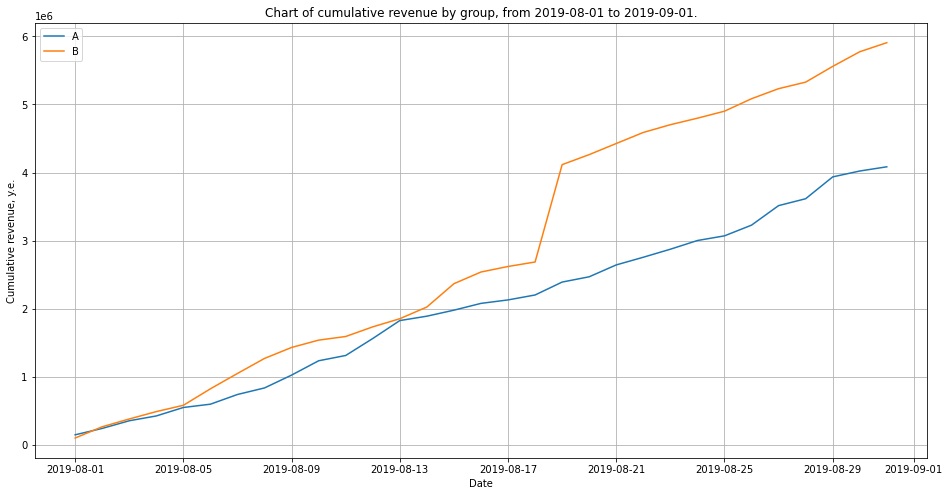

In [46]:
plt.figure(figsize = (16, 8))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label = 'A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label = 'B')
plt.title('Chart of cumulative revenue by group, from 2019-08-01 to 2019-09-01.')
plt.grid()
plt.xlabel('Date')
plt.ylabel('Cumulative revenue, ¤')
plt.legend()

<b>Interim findings:</b><br/>
In the middle of the test, segment B took the lead for the rest of the test. The sharp jump, in the period from 2019-08-17 to 2019-08-21, is probably caused by an abnormally large order. In the final analysis, it is necessary to get rid of this anomaly.

### Let's plot the cumulative average check for the groups. Let's draw conclusions and make assumptions.

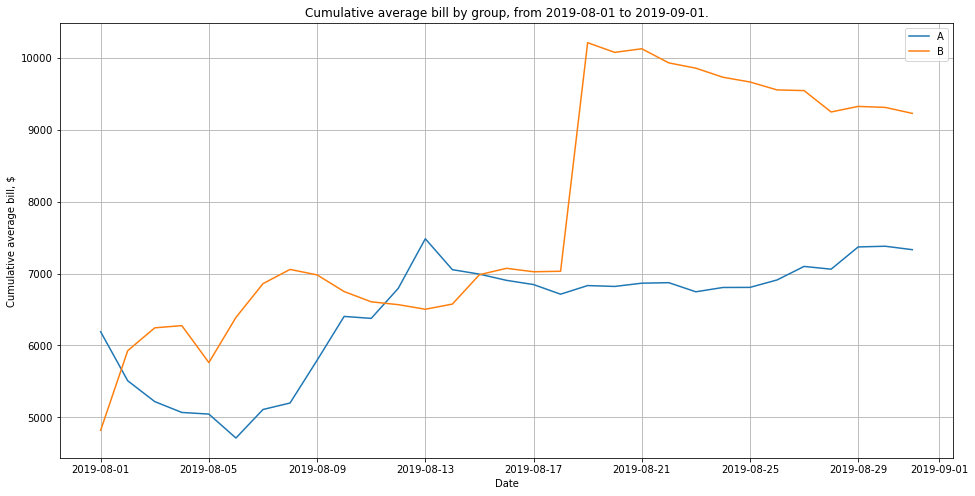

In [47]:
plt.figure(figsize = (16, 8))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'] / cumulativeRevenueA['orders'], label = 'A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'] / cumulativeRevenueB['orders'], label = 'B')
plt.title('Cumulative average bill by group, from 2019-08-01 to 2019-09-01.')
plt.grid()
plt.xlabel('Date')
plt.ylabel('Cumulative average bill, ¤')
plt.legend()

<b>Interim findings:</b><br/>
In the middle of the test, segment B took the lead and gradually declined after the peak, but was still ahead. The sharp jump, in the period from 2019-08-17 to 2019-08-21, is probably caused by an abnormally large order.

### Plot the relative change in the cumulative average check of group B to group A. Let's draw conclusions and make assumptions.

In [29]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on = 'date', right_on = 'date', how = 'left', suffixes = ['A', 'B'])

Text(0, 0.5, 'Relative change in the cumulative average check')

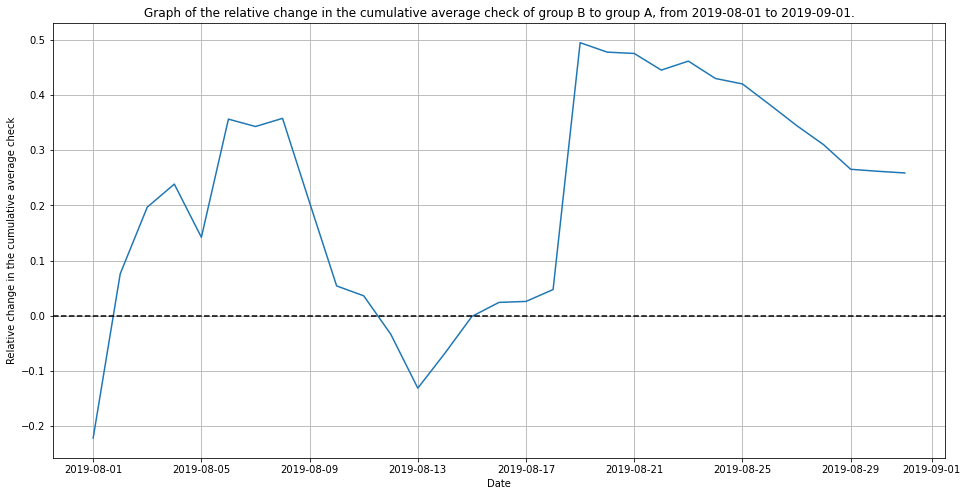

In [48]:
plt.figure(figsize = (16, 8))
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB'] / mergedCumulativeRevenue['ordersB']) / (mergedCumulativeRevenue['revenueA'] / mergedCumulativeRevenue['ordersA'])-1)
plt.axhline(y = 0, color = 'black', linestyle = '--')
plt.title('Graph of the relative change in the cumulative average check of group B to group A, from 2019-08-01 to 2019-09-01.')
plt.grid()
plt.xlabel('Date')
plt.ylabel('Relative change in the cumulative average check')

<b>Interim findings:</b><br/>
The test results varied significantly and dramatically. This was probably caused by abnormal orders.

### Plot the cumulative conversion rate by group. Make conclusions and assumptions.

In [31]:
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

cumulativeDataA = cumulativeData[cumulativeData['group'] == 'A']
cumulativeDataB = cumulativeData[cumulativeData['group'] == 'B']

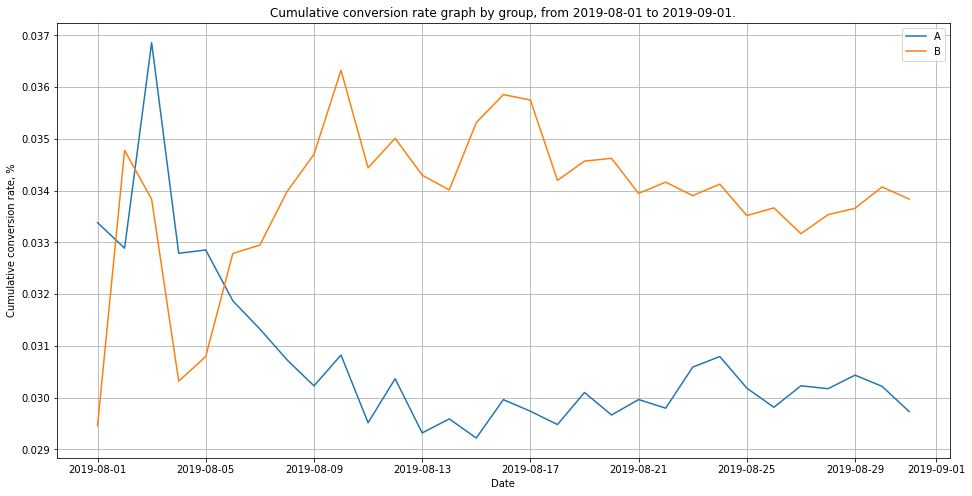

In [49]:
plt.figure(figsize = (16, 8))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label = 'A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label = 'B')
plt.title('Cumulative conversion rate graph by group, from 2019-08-01 to 2019-09-01.')
plt.grid()
plt.xlabel('Date')
plt.ylabel('Cumulative conversion rate, %')
plt.legend()

<b>Interim findings:</b><br/>
At the beginning of the test, Group A was significantly in the lead. But after the first 5 days, Group B pulled ahead and gradually stabilized at 3.4%.

### Plot the relative change in the cumulative conversion of group B to group A. Make conclusions and assumptions.

In [33]:
mergedCumulativeConversions = cumulativeDataA[['date', 'conversion']].merge(cumulativeDataB[['date', 'conversion']], left_on = 'date', right_on = 'date', how = 'left', suffixes = ['A', 'B'])

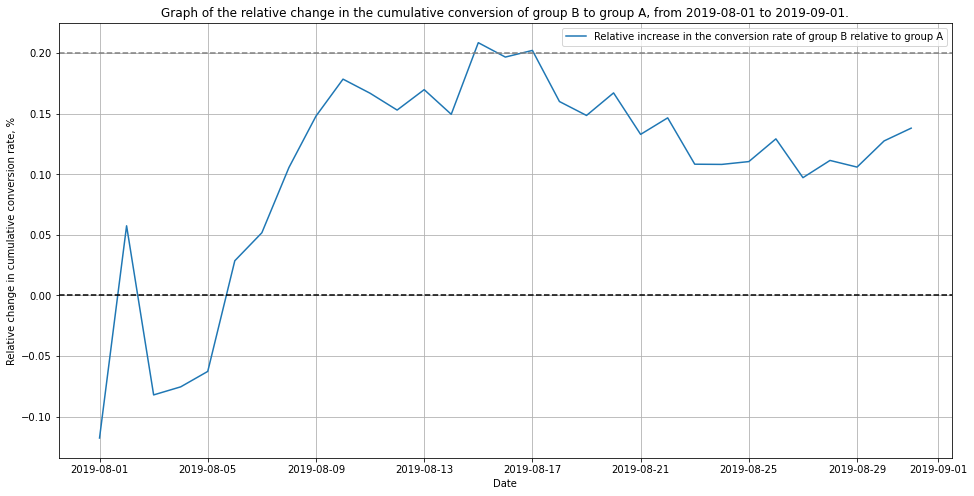

In [50]:
plt.figure(figsize = (16, 8))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB'] / mergedCumulativeConversions['conversionA'] - 1, label = "Relative increase in the conversion rate of group B relative to group A")
plt.axhline(y = 0, color = 'black', linestyle = '--')
plt.axhline(y = 0.2, color = 'grey', linestyle = '--')
plt.title('Graph of the relative change in the cumulative conversion of group B to group A, from 2019-08-01 to 2019-09-01.')
plt.grid()
plt.xlabel('Date')
plt.ylabel('Relative change in cumulative conversion rate, %')
plt.legend()

<b>Interim findings:</b><br/>
Almost from the very beginning, Group B is the leader in conversion and shows an increase relative to group A in the region of 15%.

### Let's build a dot graph of the number of orders by users. Let's draw conclusions and make assumptions.

Text(0, 0.5, 'Number of orders')

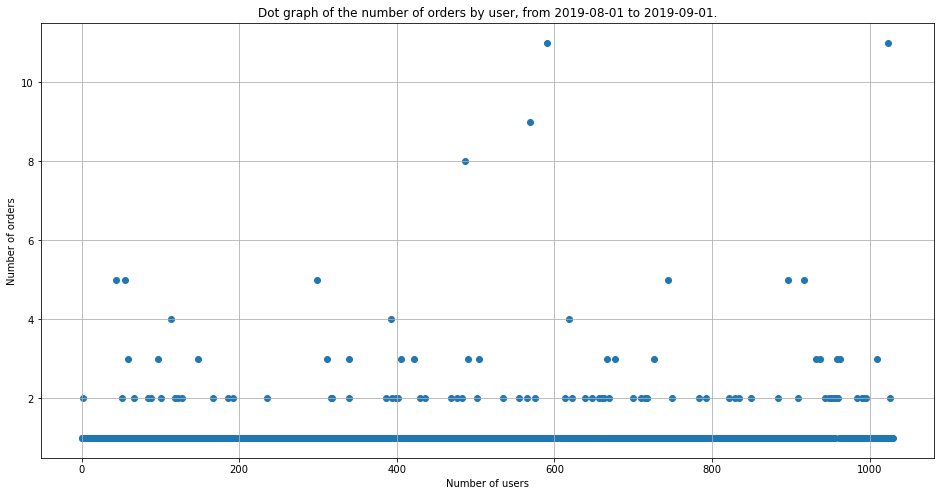

In [51]:
ordersByUsers = (
    orders.drop(['group', 'revenue', 'date'], axis=1)
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsers.columns = ['visitorId', 'orders']

plt.figure(figsize = (16, 8))
x_values = pd.Series(range(0, len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders'])
plt.title('Dot graph of the number of orders by user, from 2019-08-01 to 2019-09-01.')
plt.grid()
plt.xlabel('Number of users')
plt.ylabel('Number of orders')

<b>Interim findings:</b><br/>
There are very few users who have ordered more than 3 times. They may be abnormal

### Let's calculate the 95th and 99th percentiles of the number of orders per user. Let's choose a boundary for identifying abnormal users.

In [36]:
display(np.percentile(ordersByUsers['orders'], [95, 99]))

array([2., 4.])

<b>Interim findings:</b><br/>
No more than 5% of users made more than 2 orders and no more than 1% of users made more than 4 orders.

### Let's build a point graph of the order costs. Let's draw conclusions and make assumptions.

Text(0, 0.5, 'Cost of orders, $')

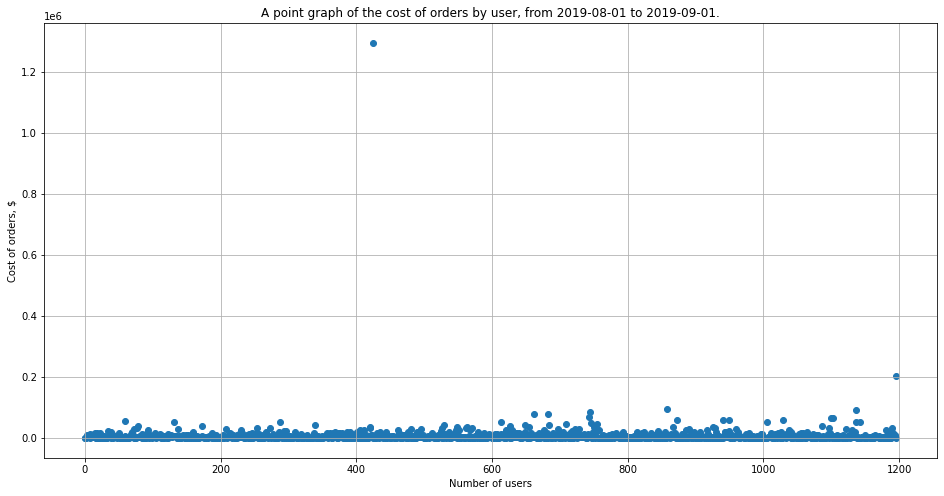

In [52]:
plt.figure(figsize = (16, 8))
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.title('A point graph of the cost of orders by user, from 2019-08-01 to 2019-09-01.')
plt.grid()
plt.xlabel('Number of users')
plt.ylabel('Cost of orders, ¤')

<b>Interim findings:</b><br/>
Everything is as expected: there are a few abnormally expensive orders. One is around 1'200'000 and around 200'000.

### Let's calculate the 95th and 99th percentiles of the cost of orders. Let's choose a boundary for determining abnormal orders.

In [38]:
display(np.percentile(orders['revenue'], [95, 99]))

array([28000. , 58233.2])

<b>Interim findings:</b><br/>
No more than 5% of orders have a receipt greater than 28'000 and no more than 1% of orders are more expensive than 58233.2.

### Let's calculate the statistical significance of differences in conversion between groups based on raw data. Let's draw conclusions and make assumptions.

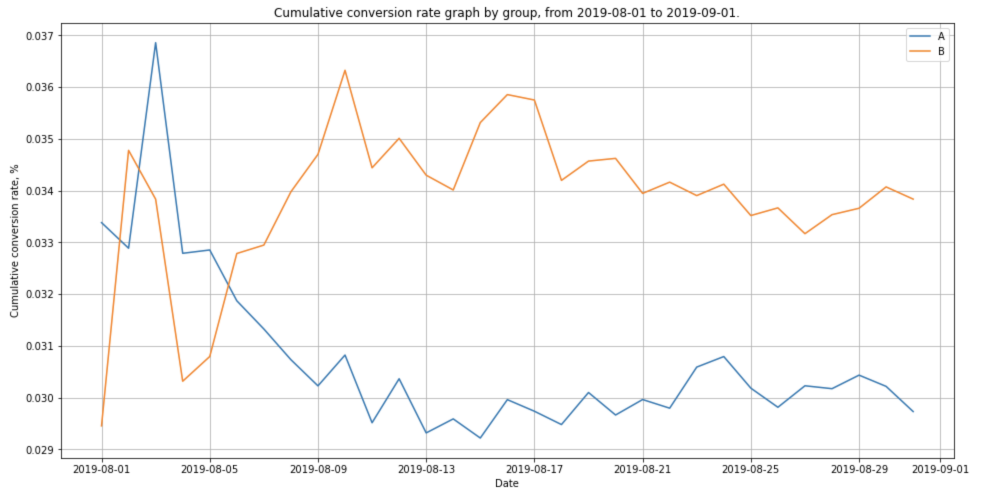
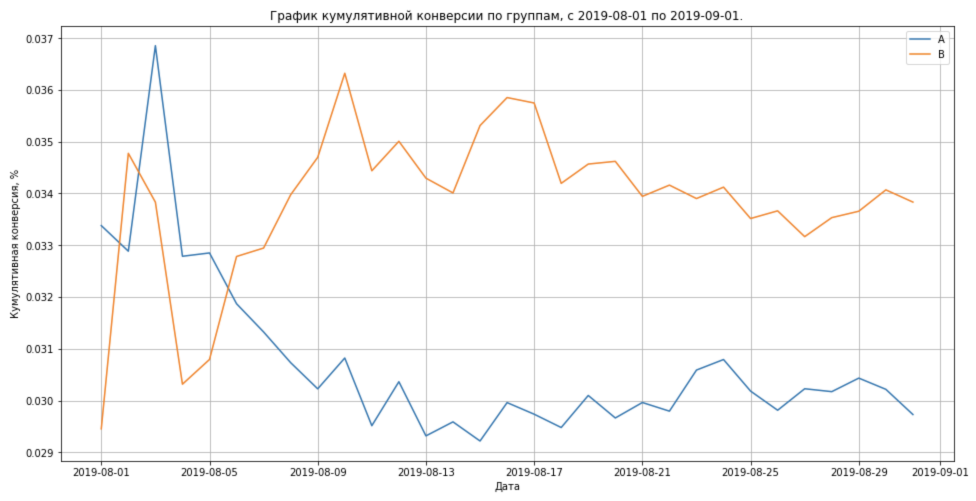

It looks like the conversion rate in group B is higher. Let's check if there is a difference using the stat test:

* H0: there are no statistically significant differences in conversion between groups A and B, according to the "raw" data.
* H1: Between groups A and B, there are statistical differences in conversion between groups, according to "raw" data.

In [39]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

print(data.head(5))

        date  ordersPerDateA  revenuePerDateA  ordersPerDateB  \
0 2019-08-01              24           148579              21   
1 2019-08-02              20            93822              24   
2 2019-08-03              24           112473              16   
3 2019-08-04              16            70825              17   
4 2019-08-05              25           124218              23   

   revenuePerDateB  ordersCummulativeA  revenueCummulativeA  \
0           101217                  24               148579   
1           165531                  44               242401   
2           114248                  68               354874   
3           108571                  84               425699   
4            92428                 109               549917   

   ordersCummulativeB  revenueCummulativeB  visitorsPerDateA  \
0                  21               101217               719   
1                  45               266748               619   
2                  61               38

In [40]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders'] 

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [53]:
# critical level of statistical significance
alpha = 0.05

results = stats.mannwhitneyu(sampleA, sampleB, True, alternative = 'two-sided')

print('p-value: ', results.pvalue)

if results.pvalue < alpha:
    print('We reject the null hypothesis: the difference is statistically significant')
else:
    print('It was not possible to reject the null hypothesis, the conclusion about the difference can not be made')

display("Group B conversion rate is higher by {0:.2%}".format((data['ordersPerDateB'].sum()/data['visitorsPerDateB'].sum())/(data['ordersPerDateA'].sum()/data['visitorsPerDateA'].sum())-1)) 

p-value:  0.016792355056752608
We reject the null hypothesis: the difference is statistically significant


'Group B conversion rate is higher by 13.81%'

<b>Interim findings:</b><br/>
According to the "raw" data, there are no differences in the conversion of groups A and B.
p-value = 0.01679 less than 0.05. We reject the null hypothesis that there are no statistically significant differences in conversion between the groups.<br/> 
The relative gain of Group B is 13.81%.

### Let's calculate the statistical significance of the differences in the average order receipt between the groups based on the "raw" data. Let's draw conclusions and make assumptions.

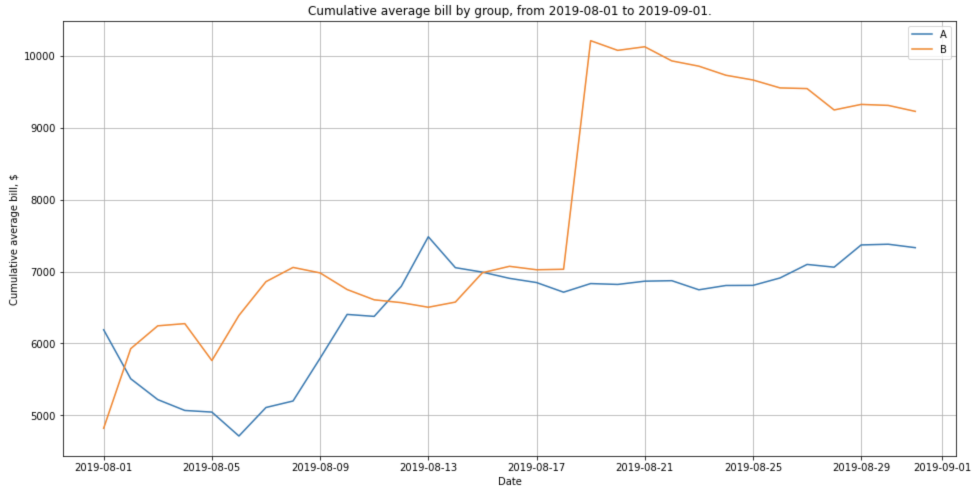
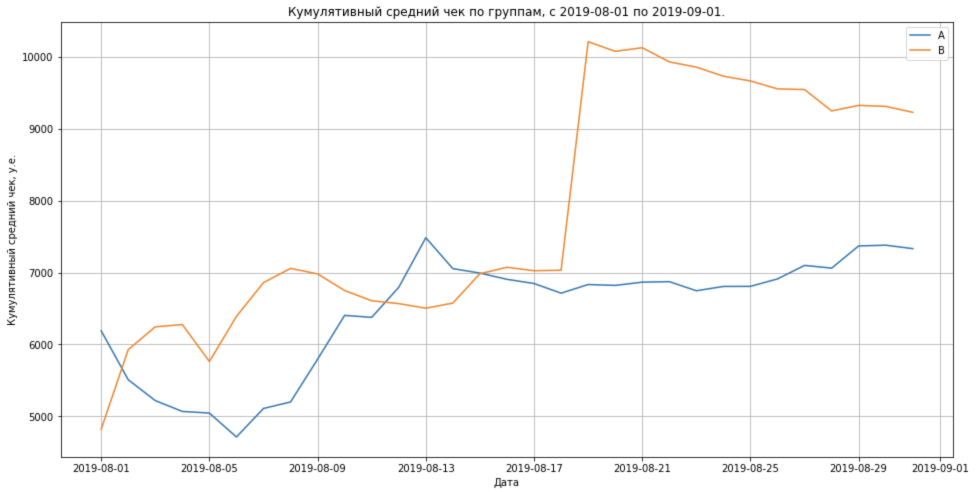

It looks like the average check in group B is higher. Let's check if there is a difference using the stat test:<br/>
< br/>
H0: between groups A and B, there are no statistically significant differences in the average check between groups, according to "raw" data.< br/>
H1: between groups A and B, there are statistical differences in the average check between groups, according to "raw" data.

In [54]:
# критический уровень статистической значимости
sampleA_1 = orders[orders['group']=='A']['revenue']
sampleB_1 = orders[orders['group']=='B']['revenue']

alpha = 0.05

results_1 = stats.mannwhitneyu(sampleA_1, sampleB_1, True, alternative = 'two-sided')

print('p-value: ', results_1.pvalue)

if results_1.pvalue < alpha:
    print('We reject the null hypothesis: the difference is statistically significant')
else:
    print('It was not possible to reject the null hypothesis, the conclusion about the difference can not be made')

display("Relative difference of the average receipt between segments'{0:.3%}'".format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))  

p-value:  0.7292909855432458
It was not possible to reject the null hypothesis, the conclusion about the difference can not be made


"Relative difference of the average receipt between segments'25.871%'"

<b>Interim findings:</b><br/>
P-value = 0.729 - between groups A and B there are statistical differences in the average check between groups, according to "raw" data.<br/> The relative difference of the average check between segments is 25.87%

### Let's calculate the statistical significance of the differences in conversion between the groups based on the "cleaned" data. Let's draw conclusions and make assumptions.

In [43]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 3]['visitorId'],
        ordersByUsersB[ordersByUsersB['orders'] > 3]['visitorId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 35000]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

In [44]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

print('{0:.5f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

0.00695
0.155


<b>Interim findings:</b><br/>
Statistical significance is achieved, as with the "raw" data. Segment B is significantly better than segment A.

### Let's calculate the statistical significance of the differences in the average order receipt between the groups based on the "cleared" data. Let's draw conclusions and make assumptions.

Let's check the statistical significance of the differences in the average check between the groups based on the cleared data. Let's check if there is a difference using the stat test:<br/>
< br/>
H0: between groups A and B, there are no statistically significant differences in the average check between groups, according to the "cleared" data.< br/>
H1: between groups A and B, there are statistical differences in the average check between groups, according to the "cleared" data.

In [45]:
print(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        True, alternative = 'two-sided')[1]
    )
)

print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

0.874
0.025


<b>Interim findings:</b><br/>
After removing the outliers, the variance decreased, and the differences in the average check were 25% 

P-value 0.874 > Alpha 0.05
Between groups A and B, there are statistical differences in the average check between groups, according to the "cleared" data.

### Let's make a decision based on the test results and explain it.

Solution options: <br/><br/> 1. Stop the test, fix the victory of one of the groups. <br/><br/> 2. Stop the test, fix the absence of differences between the groups. <br/><br/> 3. Continue the test.

<b>Conclusions from the A/B test:</b><br/>

1. There is a statistically significant difference in the conversion rate between the groups, both in the raw data and after filtering the anomalies.<br/>
According to the " raw " data, there are no differences in the conversion of groups A and B. The first number is p-value = 0.00840 less than 0.05.<br/>
So, we reject the null hypothesis that there are no statistically significant differences in conversion between the groups.<br/>
The relative gain of group B is 13.8% — the second number in the output.<br/>
<br/>

According to the "cleared" data, there are no significant differences in the conversion of groups A and B.<br/>
P-value = 0.00695 less than 0.05<br/>
The relative gain of Group B is 15.5%.<br/>

Statistical significance was achieved with both "purified" and "raw" data. Segment B is significantly better than segment A.

2. According to the "raw" and "purified" data, there is no relative significant difference in the average check between the groups.<br/>
For " raw " data:<br/>
P-value = 0.365 - there are no statistically significant differences in the average check between the groups.<br/>
The relative difference of the average receipt between segments is 25.9%<br/>
<br/>
For "cleared" data:<br/>
P-value = 0.437<br/>
The relative difference of the average receipt between segments is 25%<br/>

3. The graph of the difference in conversion between groups reports that the results of group B are better than group A: they tend to increase, and were recorded around the average value of 15%.

4. The graph of the difference in the average check fluctuates: it is he who allowed you to find the anomalies. It is impossible to draw certain conclusions from this graph.

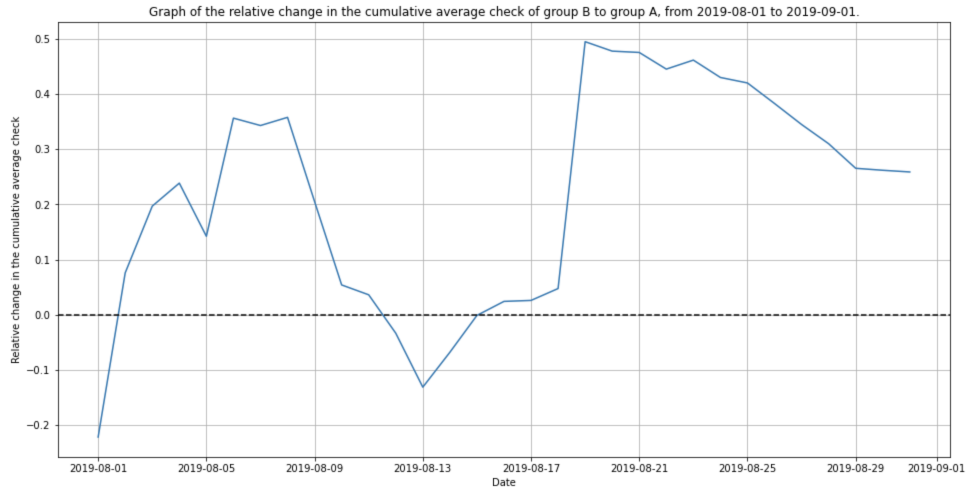
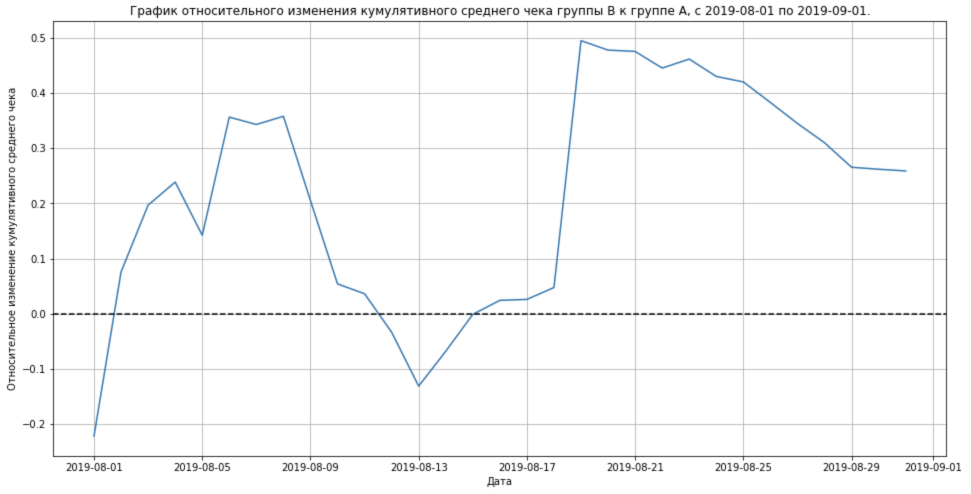

We make a decision to stop the test, record the victory of the group